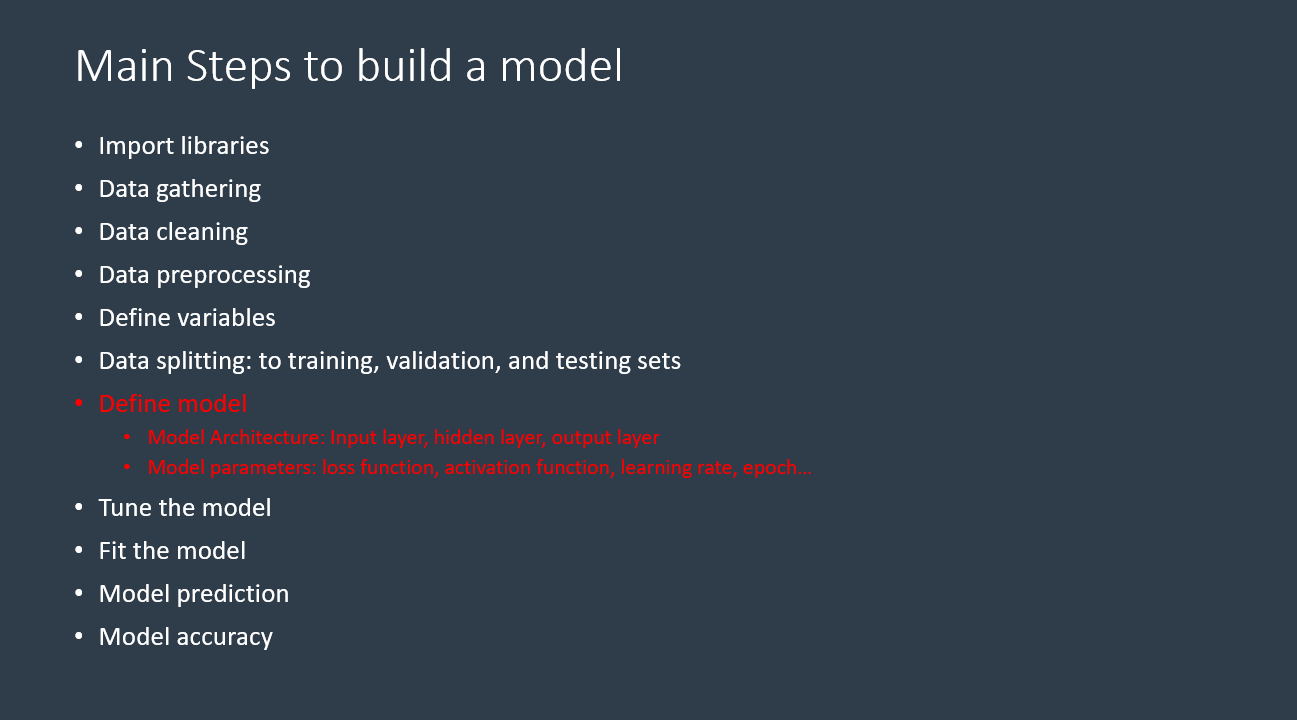

In [ ]:
#install necessary packages:
!pip install -q -U tqdm==4.28.1

In [2]:
!pip install -q -U tensorflow

In [ ]:
!pip install -q -U tensorflow_datasets

In [1]:
# import libraries:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
tfds.disable_progress_bar()

In [2]:
print(' TensorFlow version:', tf.__version__)
print(' tf.keras version:', tf.keras.__version__)
print('Is there a GPU Available:', tf.test.is_gpu_available())

 TensorFlow version: 2.0.0
 tf.keras version: 2.2.4-tf
Is there a GPU Available: True


In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


## dataset
### CAT vs DOG Classifier:
We will write a neural netowrk to classify whether images contain either a dog or a cat.  
you can find more information about the competition and the dataset in <a href="https://www.kaggle.com/c/dogs-vs-cats"> Kaggle </a>  or download the file from here: <a href='https://www.floydhub.com/fastai/datasets/cats-vs-dogs'> dataset </a>

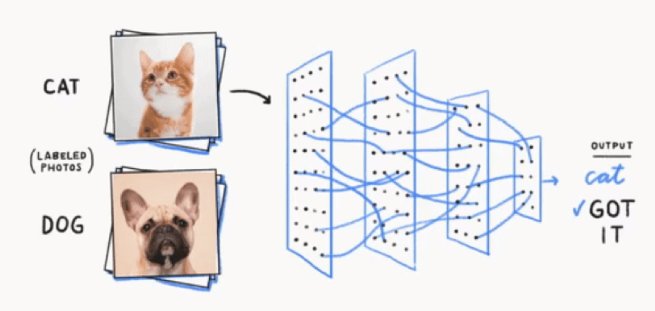

In [2]:
#load dataset:


splits = tfds.Split.ALL.subsplit([60,20, 20])

(training_set, validation_set, test_set), dataset_info = tfds.load('cats_vs_dogs', split=splits, as_supervised=True, with_info=True)

/opt/conda/lib/python3.7/site-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/2.0.1. Subsequent calls will reuse this data.


In [5]:
#explore dataset:
dataset_info

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    version=2.0.1,
    description='A large set of images of cats and dogs.There are 1738 corrupted images that are dropped.',
    urls=['https://www.microsoft.com/en-us/download/details.aspx?id=54765'],
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=23262,
    splits={
        'train': 23262,
    },
    supervised_keys=('image', 'label'),
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, Jared},
    title = {Asirra: A CAPTCHA that Exploits Interest-Aligned Manual Image Categorization},
    booktitle = {Proceedings of 14th ACM Conference on Computer and Communications Security (CCS)},
    year

In [6]:
dataset_info.features['label']

ClassLabel(shape=(), dtype=tf.int64, num_classes=2)

In [20]:
dataset_info.splits['train'].num_examples

23262

In [7]:
class_names = ['cat', 'dog']

(500, 343, 3)


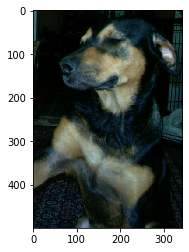

The label of this image is: 1
The class name of this image is: dog


In [17]:
for image, label in training_set.take(1):
    image = image.numpy()
    label = label.numpy()
    print(image.shape)
plt.imshow(image)
plt.show()

print('The label of this image is:', label)
print('The class name of this image is:', class_names[label])

In [21]:
#data preprocessing:
## we will create pipeline to transform the images:
batch_size = 32
image_size = 224

def format_image(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (image_size, image_size))
    image /= 255
    return image, label

#data spliting
training_batches = training_set.shuffle(23262*60//4).map(format_image).batch(batch_size).prefetch(1)
validation_batches = validation_set.map(format_image).batch(batch_size).prefetch(1)
testing_batches = test_set.map(format_image).batch(batch_size).prefetch(1)

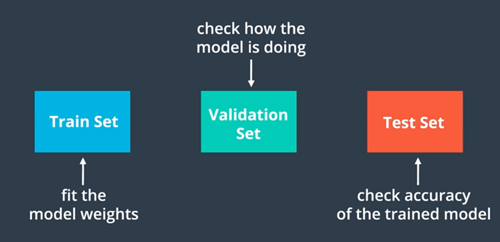

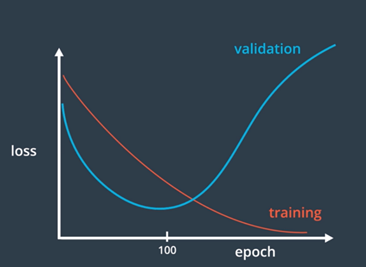

## Build the model:


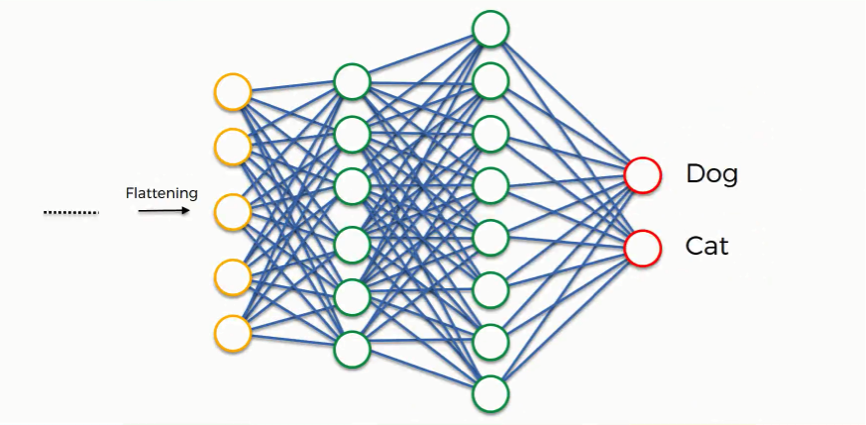

In [27]:
#define the model architecture:
tf.keras.backend.clear_session()

model = tf.keras.Sequential([
           tf.keras.layers.Flatten(input_shape =(224, 224, 3)),
           tf.keras.layers.Dense(256, activation = 'relu'),
           tf.keras.layers.Dropout(0.2),
           tf.keras.layers.Dense(128, activation = 'relu'),
           tf.keras.layers.Dropout(0.2),
           tf.keras.layers.Dense(64, activation = 'relu'),
           tf.keras.layers.Dropout(0.2),
           tf.keras.layers.Dense(2, activation = 'softmax')
])

#define the necesserily parameters:
model.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
# Stop training when there is no improvement in the validation loss for 5 consecutive epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Save the Model with the lowest validation loss
save_best = tf.keras.callbacks.ModelCheckpoint('./best_model.h5',
                                               monitor='val_loss',
                                               save_best_only=True)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 150528)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               38535424  
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0

In [31]:
#extra:
#get the wights and biases of the model:
model.get_weights()

[array([[-3.5106107e-03, -1.5388536e-03, -5.9289029e-03, ...,
         -2.7511590e-03,  7.9361303e-04,  4.4565480e-03],
        [ 4.4007348e-03,  2.4514999e-03, -6.0129277e-03, ...,
          5.7375170e-03, -1.5191818e-03,  4.4256812e-03],
        [ 4.8868600e-03, -6.2019839e-03, -8.4594497e-04, ...,
         -1.3972777e-03,  5.1126853e-03, -2.2748783e-03],
        ...,
        [ 6.3060690e-03,  3.2316884e-03, -5.6348653e-03, ...,
         -3.8279356e-03, -5.8823759e-03,  2.3062434e-03],
        [-5.6103477e-03, -5.1435572e-03,  4.3607112e-03, ...,
          2.5037620e-03, -5.9975828e-03, -6.1705941e-04],
        [-5.4921885e-03,  5.6191748e-03, -4.4186302e-03, ...,
          3.6517624e-05, -1.0435106e-03, -2.0842282e-03]], dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.

In [32]:
history = model.fit(training_batches,
                    epochs = 10,
                    validation_data=validation_batches,
                    callbacks=[early_stopping, save_best])


Epoch 1/10
437/437 [==============================] - 46s 106ms/step - loss: 2.5864 - accuracy: 0.4988 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
437/437 [==============================] - 42s 96ms/step - loss: 0.7055 - accuracy: 0.4912 - val_loss: 0.6931 - val_accuracy: 0.4963
Epoch 3/10
437/437 [==============================] - 42s 96ms/step - loss: 0.6932 - accuracy: 0.4971 - val_loss: 0.6932 - val_accuracy: 0.4963
Epoch 4/10
437/437 [==============================] - 43s 98ms/step - loss: 0.6932 - accuracy: 0.4999 - val_loss: 0.6932 - val_accuracy: 0.4961
Epoch 5/10
437/437 [==============================] - 42s 96ms/step - loss: 0.6932 - accuracy: 0.4997 - val_loss: 0.6931 - val_accuracy: 0.5041
Epoch 6/10
437/437 [==============================] - 42s 95ms/step - loss: 0.6932 - accuracy: 0.4958 - val_loss: 0.6932 - val_accuracy: 0.4963


In [43]:
history.history

{'loss': [2.586946561408145,
  0.7005718765852277,
  0.693226141291797,
  0.693212147042134,
  0.6932191431096013,
  0.6932350346799914],
 'accuracy': [0.49878398,
  0.49120173,
  0.49706724,
  0.49992847,
  0.49971387,
  0.4957797],
 'val_loss': [0.6929282468475707,
  0.6931036955689731,
  0.6931603122247408,
  0.6931714419632742,
  0.6930848449876864,
  0.6931842647186698],
 'val_accuracy': [0.50452393,
  0.49633777,
  0.49633777,
  0.49612236,
  0.50409305,
  0.49633777]}

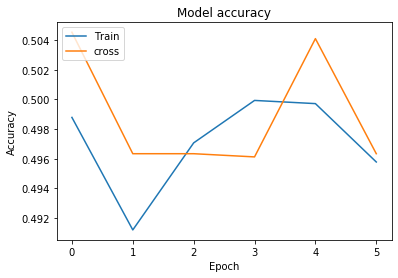

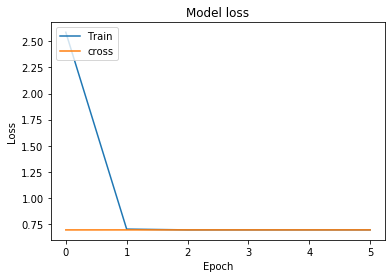

In [40]:
#extra point:
## potting learning curve:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'cross'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'cross'], loc='upper left')
plt.show()

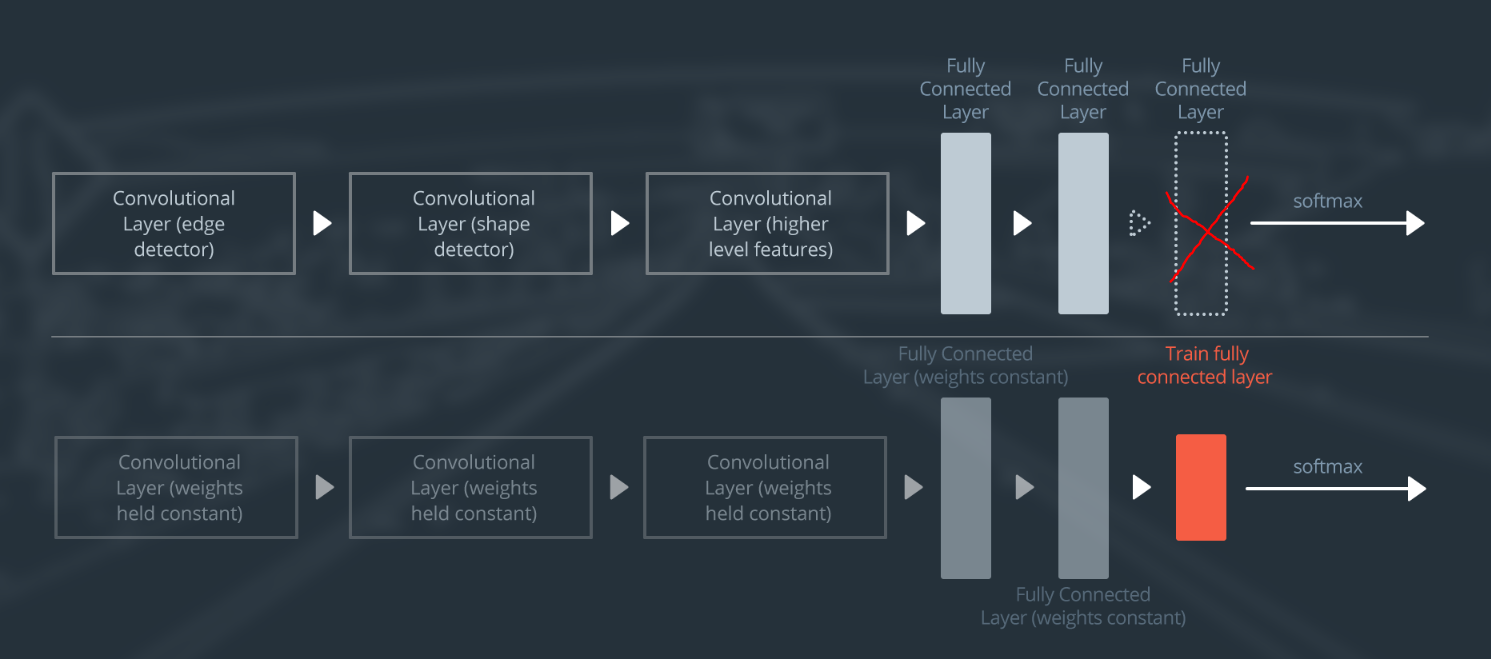

In [46]:
#transfer learning technique:
#pretined model:
## extract the pretrined model with out the output layer:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL, input_shape=(image_size, image_size,3))
# pause/freeze the parmaters of pretrained model:
feature_extractor.trainable = False
# build the model by insert the pretrained model + your classifier layers:
model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(2, activation = 'softmax')
])

#define the necesserily parameters:
model.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
# Stop training when there is no improvement in the validation loss for 5 consecutive epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Save the Model with the lowest validation loss
save_best = tf.keras.callbacks.ModelCheckpoint('./best_model.h5',
                                               monitor='val_loss',
                                               save_best_only=True)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [47]:
history = model.fit(training_batches,
                    epochs = 10,
                    validation_data=validation_batches,
                    callbacks=[early_stopping, save_best])


Epoch 1/10
437/437 [==============================] - 62s 142ms/step - loss: 0.0602 - accuracy: 0.9797 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
437/437 [==============================] - 53s 122ms/step - loss: 0.0328 - accuracy: 0.9891 - val_loss: 0.0332 - val_accuracy: 0.9882
Epoch 3/10
437/437 [==============================] - 53s 121ms/step - loss: 0.0268 - accuracy: 0.9921 - val_loss: 0.0306 - val_accuracy: 0.9892
Epoch 4/10
437/437 [==============================] - 52s 119ms/step - loss: 0.0209 - accuracy: 0.9930 - val_loss: 0.0336 - val_accuracy: 0.9888
Epoch 5/10
437/437 [==============================] - 52s 120ms/step - loss: 0.0192 - accuracy: 0.9941 - val_loss: 0.0323 - val_accuracy: 0.9879
Epoch 6/10
437/437 [==============================] - 52s 120ms/step - loss: 0.0165 - accuracy: 0.9948 - val_loss: 0.0341 - val_accuracy: 0.9892
Epoch 7/10
437/437 [==============================] - 52s 120ms/step - loss: 0.0162 - accuracy: 0.9948 - val_loss: 0.0444 

In [49]:
#model accuracy:
loss, accuracy = model.evaluate(testing_batches) 

145/145 [==============================] - 11s 78ms/step - loss: 0.0331 - accuracy: 0.9886


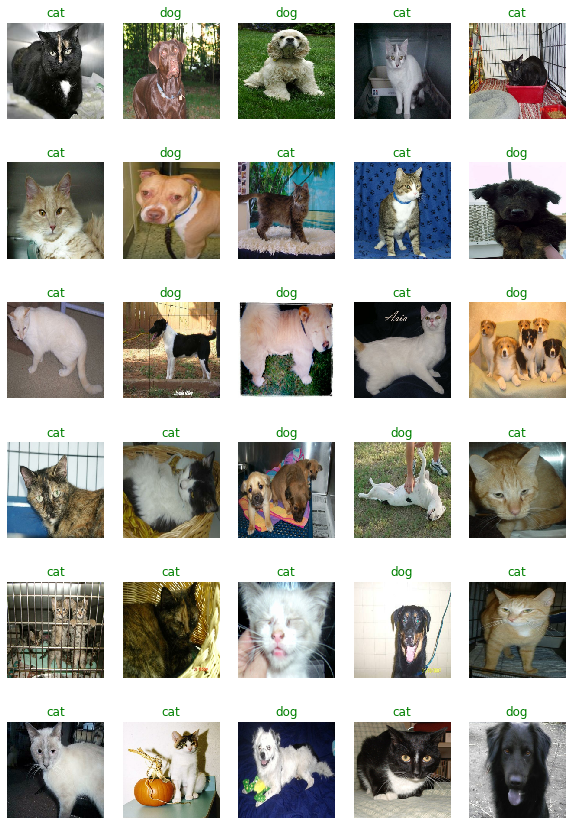

In [55]:
for image_batch, label_batch in testing_batches.take(1):
    ps = model.predict(image_batch)
    images = image_batch.numpy().squeeze()
    labels = label_batch.numpy()

plt.figure(figsize=(10,15))

for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(images[n], cmap = plt.cm.binary)
    color = 'green' if np.argmax(ps[n]) == labels[n] else 'red'
    plt.title(class_names[np.argmax(ps[n])], color=color)
    plt.axis('off')

In [60]:
model_2 = tf.keras.models.load_model('./best_model.h5',custom_objects={'KerasLayer':hub.KerasLayer})
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [62]:
#save the model:
model.save('./test_model.h5')

#load the model:
model_2 = tf.keras.models.load_model('./test_model.h5',custom_objects={'KerasLayer':hub.KerasLayer})

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________
